project 1 - discovery

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from scipy.stats import linregress
from pprint import pprint
from sodapy import Socrata


In [2]:
# Authenticated client request
request_url = Socrata("data.sonomacounty.ca.gov", "svXzQDyVcEYVmqw6LDWsmj7VP",
                 username="rondajoy@gmail.com", password="Flwrchild75", timeout=500)

# return as JSON from API then converted to Python list of dictionaries by sodapy
results = request_url.get("924a-vesw", limit=26000)

# Convert to pandas DataFrame
results_df = pd.DataFrame(results)
results_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25295 entries, 0 to 25294
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         18667 non-null  object
 1   type                         25295 non-null  object
 2   breed                        25295 non-null  object
 3   color                        25295 non-null  object
 4   sex                          25295 non-null  object
 5   size                         25260 non-null  object
 6   date_of_birth                18977 non-null  object
 7   impound_number               25295 non-null  object
 8   kennel_number                25271 non-null  object
 9   id                           25295 non-null  object
 10  intake_date                  25295 non-null  object
 11  outcome_date                 25123 non-null  object
 12  days_in_shelter              25295 non-null  object
 13  intake_type                  25

---

In [3]:
# delete unnecessary column
del results_df[':@computed_region_dig5_f3vy']
del results_df['intake_total']
del results_df['kennel_number']

# transform data type for intake and outcome (date) columns
results_df = results_df.astype({'intake_date':'datetime64[ns]',
                                'outcome_date':'datetime64[ns]',
                                'date_of_birth':'datetime64[ns]'})

# Create date features for grouping
results_df['yr_intake']=results_df.intake_date.dt.year
results_df['mon_intake']=results_df.intake_date.dt.month

# Check for outliers via groupby year
results_df['yr_intake'].unique()
results_df.groupby('yr_intake').count()


,name,type,breed,color,sex,size,date_of_birth,impound_number,id,intake_date,...,intake_subtype,outcome_type,outcome_subtype,intake_condition,outcome_condition,intake_jurisdiction,outcome_jurisdiction,zip_code,location,mon_intake
yr_intake,,,,,,,,,,,,,,,,,,,,,
2013,108,120,120,120,120,120,107,120,120,120,...,120,120,120,120,120,120,101,101,101,120
2014,2500,3216,3216,3216,3216,3208,2705,3216,3216,3216,...,3216,3216,3213,3216,3205,3216,2774,2758,2758,3216
2015,2430,3199,3199,3199,3199,3195,2510,3199,3199,3199,...,3199,3197,3195,3199,3194,3199,2740,2718,2718,3199
2016,2458,3235,3235,3235,3235,3231,2494,3235,3235,3235,...,3235,3233,3225,3235,3228,3235,2748,2742,2742,3235
2017,2323,3154,3154,3154,3154,3150,2337,3154,3154,3154,...,3154,3154,3089,3154,3150,3154,2738,2689,2689,3154
2018,2168,3081,3081,3081,3081,3077,2195,3081,3081,3081,...,3081,3078,3058,3081,3023,3081,2669,2673,2673,3081
2019,2038,2787,2787,2787,2787,2781,1976,2787,2787,2787,...,2787,2787,2746,2787,2714,2787,2457,2482,2482,2787
2020,1241,1666,1666,1666,1666,1665,1241,1666,1666,1666,...,1666,1664,1555,1666,1549,1666,1468,1463,1463,1666
2021,1247,1720,1720,1720,1720,1719,1219,1720,1720,1720,...,1720,1719,1665,1720,1657,1720,1490,1484,1484,1720


In [4]:
# Incomplete data for year(s) 2013 & 2023. Drop all data for those years.
results_df = results_df[(results_df['yr_intake']>2013) & (results_df['yr_intake']<2023)]

# Analysis will be heavily dependant upon "outcome type" so filter data to eliminate blank records.
# Filter out blank values by creating a new dataframe.
shelter_df = results_df.dropna(subset=['outcome_type']).copy()

# Replace missing values with either "missing" or "0" if numerical
shelter_df['name'].fillna('MISSING',inplace=True)
shelter_df['size'].fillna('MISSING',inplace=True)

# Verify successful
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24163 entries, 0 to 25294
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  24163 non-null  object        
 1   type                  24163 non-null  object        
 2   breed                 24163 non-null  object        
 3   color                 24163 non-null  object        
 4   sex                   24163 non-null  object        
 5   size                  24163 non-null  object        
 6   date_of_birth         18157 non-null  datetime64[ns]
 7   impound_number        24163 non-null  object        
 8   id                    24163 non-null  object        
 9   intake_date           24163 non-null  datetime64[ns]
 10  outcome_date          24163 non-null  datetime64[ns]
 11  days_in_shelter       24163 non-null  object        
 12  intake_type           24163 non-null  object        
 13  intake_subtype  

In [5]:
# Determine age on intake date
# Calculate difference between "intake_date" and "date_of_birth"
age_delta = shelter_df["intake_date"] - shelter_df["date_of_birth"]

# Convert value to numeric year(s)
age_yrs = age_delta/np.timedelta64(1, 'Y')

# Extract the number of complete months and remaining (partial) months
age_yrs = age_yrs.round(2)

shelter_df["Age at Intake (years)"] = age_yrs
#shelter_df.to_csv("SoCoShelter.csv", index=False)
shelter_df.head(25)

,name,type,breed,color,sex,size,date_of_birth,impound_number,id,intake_date,...,outcome_subtype,intake_condition,outcome_condition,intake_jurisdiction,outcome_jurisdiction,zip_code,location,yr_intake,mon_intake,Age at Intake (years)
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,2009-10-29,K22-043412,A396382,2022-12-26,...,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404,"{'latitude': '38.43807', 'longitude': '-122.71...",2022,12,13.16
9,MISSING,CAT,DOMESTIC LH,GRAY/WHITE,Spayed,SMALL,2011-06-26,K22-043405,A414520,2022-12-23,...,DOA,UNKNOWN,DEAD,COUNTY,SANTA ROSA,95403,"{'latitude': '38.51311', 'longitude': '-122.75...",2022,12,11.49
10,OSO,DOG,LABRADOR RETR,BROWN,Neutered,X-LRG,2006-06-28,K16-018664,A234388,2016-04-29,...,OVER THE COUNTER_MCHIP,HEALTHY,HEALTHY,*WINDSOR,COUNTY,95436,"{'latitude': '38.47569', 'longitude': '-122.89...",2016,4,9.84
11,FELLA,CAT,DOMESTIC SH,BRN TABBY/WHITE,Neutered,KITTN,2018-07-06,K18-029708,A375763,2018-09-04,...,WALKIN,HEALTHY,HEALTHY,COUNTY,OUT OF COUNTY,89423,"{'latitude': '39.03496000000007', 'longitude':...",2018,9,0.16
13,LEXI,DOG,AUST CATTLE DOG,WHITE/BLACK,Spayed,MED,2022-04-01,K22-041089,A410937,2022-04-11,...,OVER THE COUNTER_PRVS,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407,"{'latitude': '38.41483', 'longitude': '-122.72...",2022,4,0.03
15,KENJI,DOG,AKITA,TRICOLOR,Neutered,LARGE,2022-05-02,K22-042314,A412962,2022-08-23,...,OVER THE COUNTER_WALKIN,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407,"{'latitude': '38.41483', 'longitude': '-122.72...",2022,8,0.31
16,SONOMA,OTHER,HORSE,BROWN/BLACK,Female,LARGE,NaT,K21-040124,A407842,2021-11-15,...,NaN,UNKNOWN,TREATABLE/REHAB,COUNTY,COUNTY,95404,"{'latitude': '38.43807', 'longitude': '-122.71...",2021,11,NaN
17,COCO,DOG,GREAT PYRENEES,WHITE,Spayed,LARGE,2022-02-21,K22-042491,A413774,2022-09-10,...,OVER THE COUNTER_WEB,UNKNOWN,PENDING,COUNTY,COUNTY,95465,"{'latitude': '38.4071', 'longitude': '-122.947...",2022,9,0.55
18,*TABITHA,CAT,DOMESTIC SH,BLACK,Spayed,KITTN,2022-07-14,K22-042942,A413866,2022-10-25,...,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95589,"{'latitude': '40.06054', 'longitude': '-123.96...",2022,10,0.28
20,NAKITA,DOG,SIBERIAN HUSKY,BLACK/WHITE,Female,LARGE,NaT,K21-040409,A414560,2021-12-30,...,OVER THE COUNTER_PRVS,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407,"{'latitude': '38.41483', 'longitude': '-122.72...",2021,12,NaN


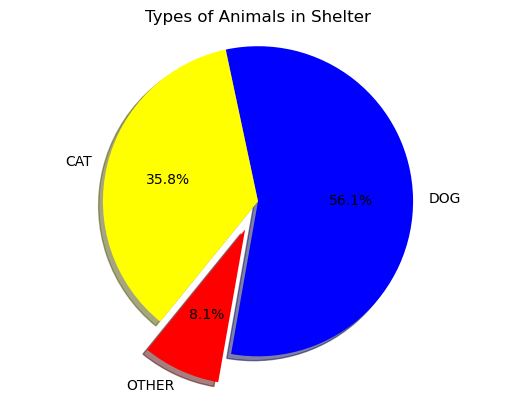

In [6]:
# Isolate to "type" of animal and count occurrence of each value.
type_counts = shelter_df["type"].value_counts()

# Create pie chart
colors=["blue", "yellow", "red"]
explode=(0, 0, 0.2)
plt.pie(type_counts, labels=type_counts.index, explode=explode,
        autopct='%1.1f%%', colors=colors, shadow=True, startangle=260)
plt.title("Animal Species Received at Shelter from 2014-2022")
plt.axis("equal")
plt.show()


In [10]:
# Specify 'OTHER' category of animal at shelter
other_df = shelter_df.loc[(shelter_df["type"]=="OTHER"),:]
other_df.info()

# Count occurrence of each value
#other_counts = other_df['breed'].value_counts()
#other_counts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 16 to 25294
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   1954 non-null   object        
 1   type                   1954 non-null   object        
 2   breed                  1954 non-null   object        
 3   color                  1954 non-null   object        
 4   sex                    1954 non-null   object        
 5   size                   1954 non-null   object        
 6   date_of_birth          612 non-null    datetime64[ns]
 7   impound_number         1954 non-null   object        
 8   id                     1954 non-null   object        
 9   intake_date            1954 non-null   datetime64[ns]
 10  outcome_date           1954 non-null   datetime64[ns]
 11  days_in_shelter        1954 non-null   object        
 12  intake_type            1954 non-null   object        
 13  i

C:\Users\ronda\AppData\Local\Temp\ipykernel_17124\275761889.py:29: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alt_species = top_10.append(pd.Series(remaining, index=['All Other']))


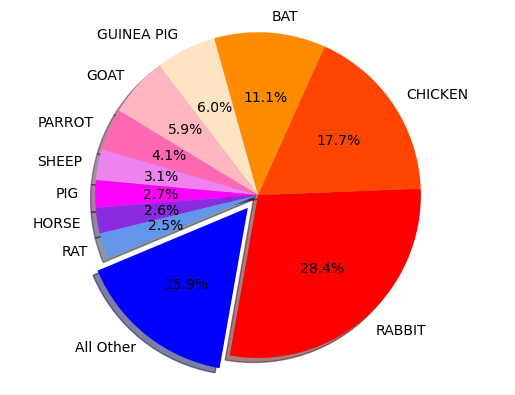

In [22]:
# Need to consolidate'breed' values for fair representation of all species
new_df = other_df.copy()
new_df['breed'] = new_df['breed'].replace(['RABBIT SH', 'LOP-MINI', 'REX', 'ENGLISH SPOT/MIX',
                                               'LOP-ENGLISH', 'RABBIT LH', 'HOTOT', 'LOP-HOLLAND',
                                               'DUTCH/MIX', 'CALIFORNIAN', 'NEW ZEALAND WHT',
                                               'CALIFORNIAN/MIX', 'HAVANA/MIX', 'LOP-AMER FUZZY',
                                               'DUTCH', 'ENGLISH SPOT', 'HAVANA', 'LOP-FRENCH',
                                               'LOP-ENGLISH/MIX', 'HOTOT/MIX', 'FLEMISH GIANT',
                                               'HARLEQUIN/MIX', 'ANGORA-SATIN/MIX','LOP-HOLLAND/MIX',
                                               'LOP-MINI/MIX', 'NETHERLND DWARF'], 'RABBIT')

new_df['breed'] = new_df['breed'].replace(['BOER', 'GOAT/PYGMY', 'GOAT/ALPINE', 'GOAT/LA MANCHA',
                                           'GOAT/BOER'], 'GOAT')

new_df['breed'] = new_df['breed'].replace(['PARAKEET', 'COCKATIEL', 'TROPICAL', 'MACAW'], 'PARROT')
new_df['breed'] = new_df['breed'].replace(['HAMSTER'], 'GUINEA PIG')
new_df['breed'] = new_df['breed'].replace(['POTBELLY PIG'], 'PIG')
new_df['breed'] = new_df['breed'].replace(['QUARTER HORSE'], 'HORSE')
new_df['breed'] = new_df['breed'].replace(['CHICKEN/BANTAM'], 'CHICKEN')

# Count occurrence of each new value
new_counts = new_df['breed'].value_counts()

# Extract the top 10 values and their counts
top_10 = new_counts.head(10)
remaining = new_counts[10:].sum()

# Create a new series with the top 10 values + "All Other" category
alt_species = top_10.append(pd.Series(remaining, index=['All Other']))

# Plot the series
colors=["red", "orangered", "darkorange", "bisque", "lightpink", "hotpink", "violet",
        "magenta", "blueviolet", "cornflowerblue", "blue"]
explode=(0, 0, 0, 0,0,0,0,0,0,0,0.1)
plt.pie(alt_species, labels=alt_species.index, explode=explode, autopct='%1.1f%%',
        colors=colors, shadow=True, startangle=260)
plt.axis('equal')
plt.show()